### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.states import Statevector
from time import sleep


In [4]:
from ipynb.fs.full.ansatz import gen_expressive_ansatz_1qubit
from mub_state_gen import generate_mub_state_circ
from experiment_utils import run_and_record_landscape, run_and_record_vqe_expressive_1q
from landscape import TotalLandscapeResult, calculate_energy_landscape

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


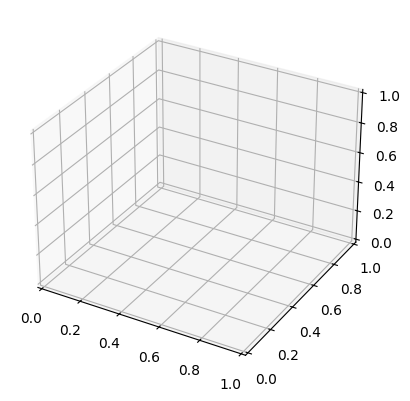

In [5]:
ax = plt.axes(projection="3d")
print(type(ax))

In [6]:
def sphere_to_cart(theta, phi) -> tuple[np.float64, np.float64, np.float64]:
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return x,y,z

### Draw regular sphere + line Axes

In [7]:
def draw_bloch():
    thetas = np.linspace(0, 2*np.pi, 100)
    phis = np.linspace(0, np.pi, 100)

    x = np.outer(np.cos(thetas), np.sin(phis))
    y = np.outer(np.sin(thetas), np.sin(phis))
    z = np.outer(np.ones(np.size(thetas)), np.cos(phis))

    # coords = [sphere_to_cart(*point) for point in zip(thetas, phis)]
    # xs, ys, zs = (np.array(l) for l in zip(*coords))
    # print(type(xs))
    # ax.plot_surface(xs, ys, zs)

    ax = plt.axes(projection="3d")
    plt.grid(False)
    plt.axis('off')
    ax.plot_surface(x,y,z, alpha=0.15, color="Gray")

    L=1.5

    # Axes
    ax.set_xlim(-L,L)
    ax.set_ylim(-L,L)
    ax.set_zlim(-L,L)
    # ax.set_ylabel('Y axis')
    # ax.set_zlabel('Z axis')

    ax.quiver(-1.5,0,0, 3,0,0, arrow_length_ratio=0.1)
    ax.quiver(0,-1.5,0, 0,3,0, arrow_length_ratio=0.1)
    ax.quiver(0,0,-1.5, 0,0,3, arrow_length_ratio=0.1)
    
    ax.text(1.5,0,0,'X axis')
    ax.text(0,1.5,0,'Y axis')
    ax.text(0,0,1.5,'Z axis')
    
    
    # Reference Points
    ax.text(0,0,1,"|0>")
    ax.text(0,0,-1,"|1>")
    ax.text(1,0,0,"|+>")
    ax.text(-1,0,0,"|->")
    return ax
    # plt.show()


### From State to Bloch Sphere polar coords

In [8]:
def vec_to_sphericals(vec: np.array) -> tuple[np.float64, np.float64]:
    # vec = state.data
    alpha, beta = vec[0], vec[1]
    real_alpha = np.abs(alpha)
    phi = 2 * np.arccos(real_alpha)
    theta = np.angle(beta) - np.angle(alpha)
    return theta, phi
    
def qubit_to_sphericals(state: Statevector) -> tuple[np.float64, np.float64]:
    return vec_to_sphericals(state.data)

In [9]:
point = vec_to_sphericals(np.array([np.sqrt(0.5), 1*np.sqrt(0.5)]))

### draw onto the sphere

In [10]:
def add_to_sphere(ax, theta, phi, color="Blue"):
    x,y,z = sphere_to_cart(theta, phi)
    ax.scatter3D([x], [y], [z], color=color)

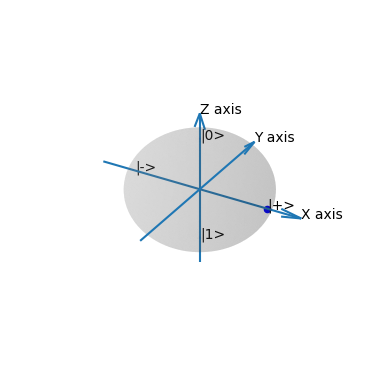

In [11]:
ax = draw_bloch()
add_to_sphere(ax, *point)

### Together with MUB point generation

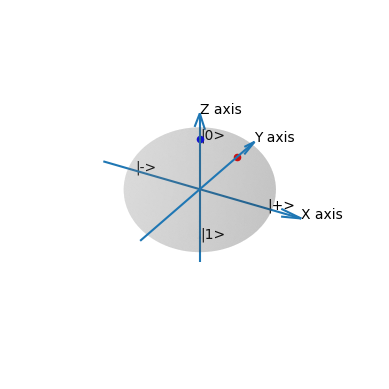

In [10]:
state_0 = Statevector.from_instruction(generate_mub_state_circ(0,0,1,[0]))
ax = draw_bloch()
add_to_sphere(ax, *qubit_to_sphericals(state_0))
state_plusi = Statevector.from_instruction(generate_mub_state_circ(0,2,1,[0]))
add_to_sphere(ax, *qubit_to_sphericals(state_plusi), color="RED")


## Landscaping

In [11]:
def value_to_color(val: np.float64):
    return "Blue"

def draw_MUB_values(ax: Axes3D, res: TotalLandscapeResult):
    for mub_res in res.mub_results:
        for state_res in mub_res[0]:
            color = value_to_color(state_res.value)
            state = Statevector.from_instruction(state_res.state_circuit)
            add_to_sphere(ax, *qubit_to_sphericals(state))
            


## VQE Visualization

In [12]:
def ansatz_params_to_sphericals(ansatz_params: list[np.ndarray]) -> list[tuple[np.float64, np.float64]]:
    sphericals = []
    for iter_params in ansatz_params:
        circ = gen_expressive_ansatz_1qubit()
        circ.assign_parameters(iter_params, inplace=True)
        state = Statevector.from_instruction(circ)
        sphericals.append(qubit_to_sphericals(state))
    return sphericals

## All together, now!

attempting all MUB states over the operator SparsePauliOp(['I', 'X', 'Y', 'Z'],
              coeffs=[0. +0.j, 0.5+0.j, 0. +0.j, 0.5+0.j])
Energy Landscape:


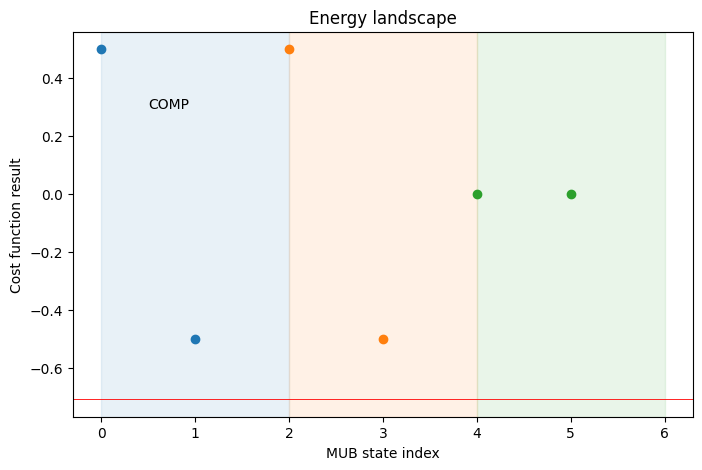

Energy Histogram:


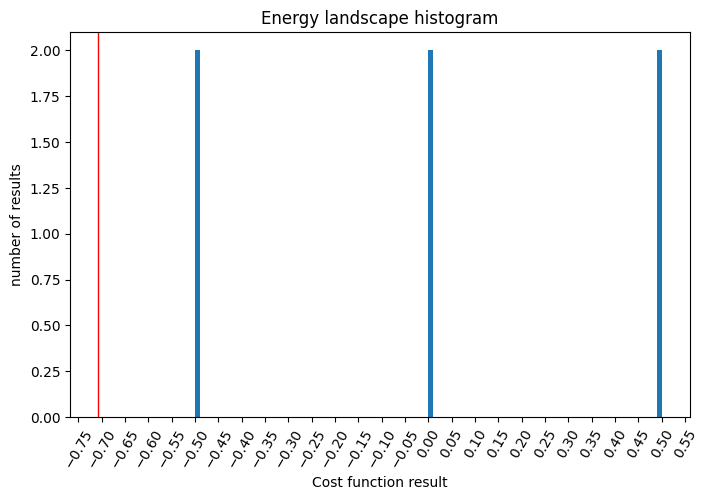

The operator SparsePauliOp(['I', 'X', 'Y', 'Z'],
              coeffs=[0. +0.j, 0.5+0.j, 0. +0.j, 0.5+0.j]) has the exact value -0.7071067811865475.
Now trying to reach the vcalue from different MUB points.
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=0) and value 0.5
10: -0.49652232221547965
running from state of index MUBIndex(subset_idx=0, mub_idx=0, basis_state_idx=1) and value -0.5
10: -0.686511268820321
running from state of index MUBIndex(subset_idx=0, mub_idx=1, basis_state_idx=0) and value 0.5
10: -0.7044153001313705
running from state of index MUBIndex(subset_idx=0, mub_idx=1, basis_state_idx=1) and value -0.5
10: -0.6823359490348516
running from state of index MUBIndex(subset_idx=0, mub_idx=2, basis_state_idx=0) and value 0.0
10: -0.7017632016843641
running from state of index MUBIndex(subset_idx=0, mub_idx=2, basis_state_idx=1) and value 0.0
10: -0.49881073077789484
20: -0.6323043521024372


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


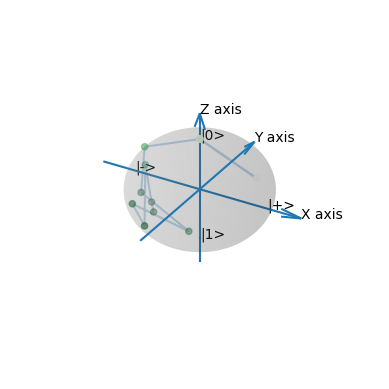

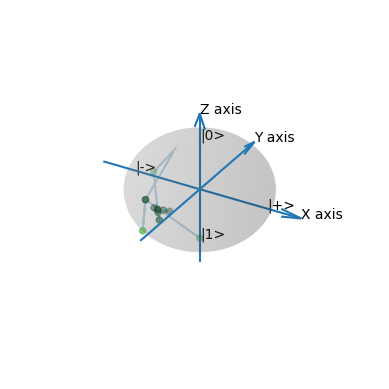

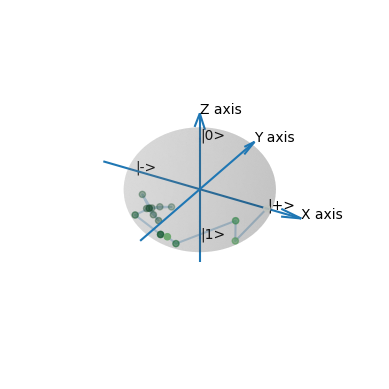

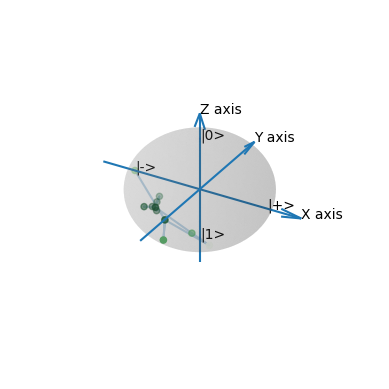

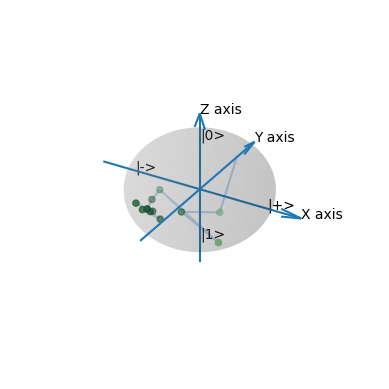

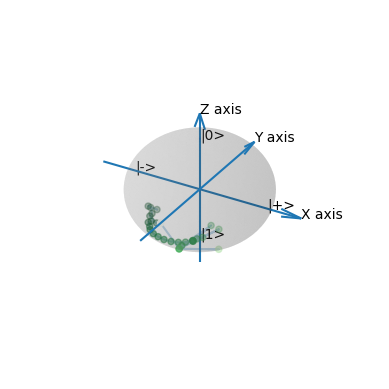

In [13]:
ham = SparsePauliOp(data= ['I', 'X', 'Y', 'Z'], coeffs= [0, 0.5, 0, 0.5])
results = run_and_record_landscape(ham, 1)
ax = draw_bloch()
draw_MUB_values(ax, results)
vqe_results = run_and_record_vqe_expressive_1q(results)
for vqe_result in vqe_results:
    thetas_as_sphericals = ansatz_params_to_sphericals(vqe_result.thetas_list)
    thetas_as_carts = [sphere_to_cart(*t) for t in thetas_as_sphericals]
    xs, ys, zs = list(zip(*thetas_as_carts))
    ax = draw_bloch()
    ax.plot3D(xs, ys, zs, alpha=0.3)
    ax.scatter3D(xs, ys, zs, c=vqe_result.costs_list, cmap='Greens_r')
    plt.show()
    
    